In [83]:
import cv2
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt
import face_recognition
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from wandb import wandb
import os
from sklearn.cluster import KMeans
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

warnings.filterwarnings("ignore")

In [3]:
# Load the model from local file
# model = load_model('best_model-b7-first.h5')

# Load model from w&b
loaded_model = wandb.restore('model-best.h5', run_path="dat550/deepfake-efficientnet/runs/29425ckm")

model = load_model(loaded_model.name)

2022-04-26 15:56:18.313980: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
detector = MTCNN()
img_size = 128

In [68]:
def read_frame(cap, sec):    
    cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    has_frame, image = cap.read()
    
    num_faces = 0
    faces_images = []

    if has_frame:
        # Find faces
        faces = detector.detect(image)
        if faces[0] is not None:
            num_faces = len(faces[0])
        if num_faces > 0:
            for i in range(num_faces):
                try:
                    accuracy = faces[1][i]
                    if(accuracy > 0.90):
                        x1 = int(faces[0][i][0])
                        y1 = int(faces[0][i][1])
                        x2 = int(faces[0][i][2])
                        y2 = int(faces[0][i][3])

                        # Add 20 % padding to each side of the face
                        padding_x = int((x2 - x1) * 0.2)
                        padding_y = int((y2 - y1) * 0.2)
                        
                        x1 = x1 - padding_x
                        y1 = y1 - padding_y
                        x2 = x2 + padding_x
                        y2 = y2 + padding_y

                        # Ensure we're inside 
                        x1 = max(0, x1)
                        y1 = max(0, y1)
                        x2 = min(image.shape[1], x2)
                        y2 = min(image.shape[0], y2)

                        face_image = image[y1-padding_y:y2+padding_y, x1-padding_x:x2+padding_x]

                        face_image = cv2.resize(face_image, (img_size, img_size))
                        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
                        faces_images.append(face_image)
                except Exception as e:
                    pass

    return has_frame, faces_images, num_faces


def get_all_faces_from_video(path, frame_rate=1):
    imagename = path.split('/')[-1].split('.')[0]
    
    # If folder exists do not preprocess it
    video_folder = f'./data/test/{frame_rate}-{imagename}'
    if not os.path.exists(video_folder):
        # Create the path 
        os.makedirs(video_folder)

        # Make a videocapture
        cap = cv2.VideoCapture(path)

        images = []
        max_faces = 0

        sec = 0
        success = True
        while success:
            success, faces_images, num_faces = read_frame(cap, sec)
            sec += frame_rate

            if(success):
                for face_image in faces_images:
                    if face_image is not None:
                        images.append(face_image)

                if num_faces > max_faces:
                    max_faces = num_faces

        # Write all the frames
        for i, face_image in enumerate(images):
            cv2.imwrite(f'{video_folder}/{max_faces}-{i}.png', face_image)
        
        return images, max_faces

    else: 
        images = []
        filenames = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith('.png')]
        if(len(filenames) == 0):
            # Delete the folder and retry 
            os.rmdir(video_folder)
            return get_all_faces_from_video(path, frame_rate)
        max_faces = int(filenames[0].split('/')[-1].split('-')[0])
        for filename in filenames:
            image = cv2.imread(os.path.join(filename), cv2.IMREAD_UNCHANGED)
            images.append(image)
        return images, 2

## Do the clustering

In [128]:
# Encode faces
def encode_faces(faces_images):
    faces_encodings = []
    indexes = []
    for i, face in enumerate(faces_images):
        face_encoding = face_recognition.face_encodings(face)
        if len(face_encoding) > 0:
            faces_encodings.append(face_encoding[0])
            indexes.append(i)

    return faces_encodings

In [132]:
def cluster_faces(faces_encodings, num_faces, faces_images, plot = False):
    try:
        clt = KMeans(n_clusters=num_faces)
        
        if len(faces_encodings) >= 2:
            clt.fit(faces_encodings)
            labels = clt.labels_
        else:
            labels = np.zeros(len(faces_encodings))


        # Find all faces in the same cluster
        clusters = []
        for label in set(labels):
            # Get indexes of faces in the cluster
            indexes = [i for i, x in enumerate(labels) if x == label]
            # Get images in the cluster
            faces = [faces_images[i] for i in indexes]
            # Add to clusters
            clusters.append(faces)
        
        if plot:
            for cluster in clusters:
                plt.figure(figsize=(10, 10))
                for d in range(min(9, len(cluster))):
                    plt.subplot(3, 3, d+1)
                    plt.imshow(cluster[d])
                    plt.axis('off')

        return clusters
    except Exception as e:
        return []

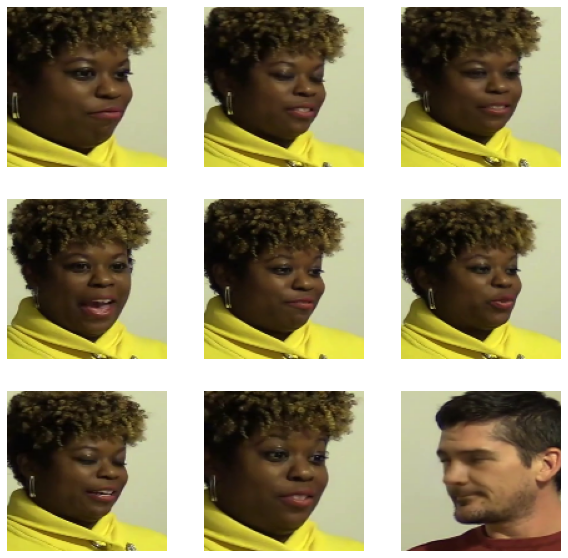

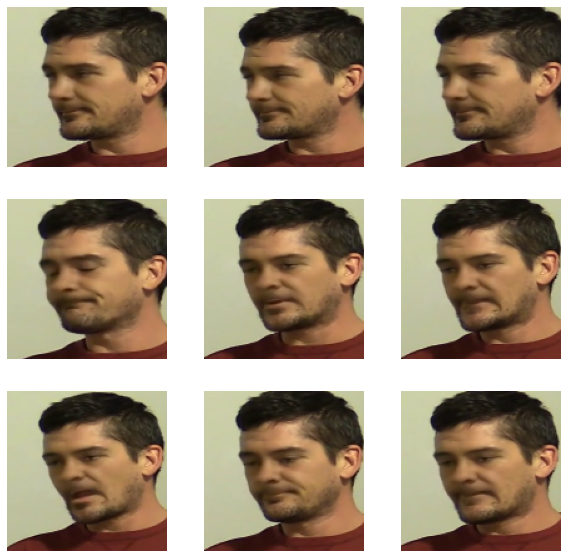

In [102]:
video_path = './data/train_sample_videos/bpwzipqtxf.mp4'
faces_images, max_faces = get_all_faces_from_video(video_path, frame_rate=0.5)
faces_encodings = encode_faces(faces_images)
clusters = cluster_faces(faces_encodings, max_faces, faces_images, plot=True)

In [110]:

def predict(clusters):
    image_data_generator = ImageDataGenerator(
        rescale = 1/255
    )
    # Create one generator for each cluster
    result = 0
    for i in range(len(clusters)):
        generator = image_data_generator.flow(
            np.reshape(clusters[i], (np.shape(clusters[i]))) , 
            batch_size=1, seed=1
        )
        predictions = model.predict(generator)
        # Calculate the average prediction
        average = 1 - np.mean(predictions, axis=0)
        if average > result:
            result = average
    return result

In [123]:
def predict_multiple(folder_path, frame_rate=1, plot=False):
    classes = ["REAL", "FAKE"]
    video_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]
    results = []
    # Read metadata from the video
    df = pd.read_json(f'{folder_path}/metadata.json').T
    for path in tqdm(video_paths):
        faces_images, num_faces = get_all_faces_from_video(path, frame_rate)
        if len(faces_images) > 0:
            video_name = path.split('/')[-1]
            faces_encodings = encode_faces(faces_images)
            clusters = cluster_faces(faces_encodings, num_faces, faces_images, plot)
            if (len (clusters) > 0):
                prediction = predict(clusters)[0]
                            
                result = {
                    'video_name': video_name,
                    'prediction': prediction,
                    'predicted_class': classes[int(np.round(prediction))],
                    'real_class': df.loc[video_name].label
                }

                results.append(result)
    return pd.DataFrame(results)

In [133]:
result = predict_multiple('./data/train_sample_videos', 2, False)

100%|██████████| 400/400 [10:18<00:00,  1.55s/it]


<AxesSubplot:>

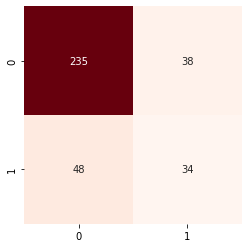

In [134]:
conf_mat = confusion_matrix(result.predicted_class, result.real_class)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Reds', fmt='d', cbar=False)

In [136]:
# Calculate accuracy
np.trace(conf_mat) / np.sum(conf_mat)

0.7577464788732394

In [137]:
# Calculate recall 
np.diag(conf_mat) / np.sum(conf_mat, axis=1)

array([0.86080586, 0.41463415])

In [138]:
# Calculate precision
np.diag(conf_mat) / np.sum(conf_mat, axis=0)

array([0.83038869, 0.47222222])

In [139]:
result

,video_name,prediction,predicted_class,real_class
0,cdaxixbosp.mp4,0.988481,FAKE,FAKE
1,btiysiskpf.mp4,0.928196,FAKE,FAKE
2,clihsshdkq.mp4,0.851158,FAKE,FAKE
3,alvgwypubw.mp4,0.996775,FAKE,FAKE
4,eqvuznuwsa.mp4,0.993572,FAKE,FAKE
...,...,...,...,...
350,dkwjwbwgey.mp4,0.668001,FAKE,FAKE
351,esckbnkkvb.mp4,0.905901,FAKE,FAKE
352,eczrseixwq.mp4,0.959852,FAKE,FAKE
353,dlrsbscitn.mp4,0.947453,FAKE,FAKE
